In [ ]:
import os
import tensorflow as tf
from tensorflow import keras

print(tf.version.VERSION)

2.8.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
drive.mount("/content/drive",force_remount= True)

Mounted at /content/drive
Mounted at /content/drive


In [ ]:
class Config:
  DATASET_PATH ="/content/drive/MyDrive/Dataset/CrossRoad1/Train_frame"
  SINGLE_TEST_PATH = "/content/drive/MyDrive/Dataset/CrossRoad1/Test_frame/Test007"
  BATCH_SIZE = 4
  EPOCHS = 3
  MODEL_PATH = "/content/drive/MyDrive/model.h5"
  MODEL_2_PATH = "/content/drive/MyDrive/model2.h5"
  GROUND_TRUTH_PATH = "/content/drive/MyDrive/Dataset/CrossRoad1/Test_frame/traffic_gt.m"

In [ ]:
import tensorflow as tf
import keras
from tensorflow.keras.layers import Conv2DTranspose, ConvLSTM2D, BatchNormalization, TimeDistributed, Conv2D
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LayerNormalization
from os import listdir
from os.path import isfile, join, isdir
import numpy as np
from PIL import Image

# New Section

In [ ]:
def get_single_test():
    sz = 250
    test = np.zeros(shape=(sz, 256, 256, 1))
    cnt = 0
    for f in sorted(listdir(Config.SINGLE_TEST_PATH)):
        #print(type(join(Config.SINGLE_TEST_PATH, f)))
        if (join(Config.SINGLE_TEST_PATH, f))[-3:] == "tif":
            img = Image.open(join(Config.SINGLE_TEST_PATH, f)).resize((256, 256))
            img = np.array(img, dtype=np.float32) / 256.0
            test[cnt, :, :, 0] = img
            cnt = cnt + 1
    print(test.shape)
    return test


In [ ]:
# 1 based indexing of frames is used here
# no of frames in each  test folder = 250
# 0 = anomalous, 1 = normal

ground_truth = []

with open(Config.GROUND_TRUTH_PATH) as file_in:
    for line in file_in:
        l = line.find('[')
        r = line.find(']')

        if l == -1 or r == -1:
            continue
        
        str = line[l+1 : r]
        str = str.split(', ')

        gt = [1] * 250 
        for s in str:
            int_list = [int(i) for i in s.split(':')]

            for i in range(int_list[0]-1, int_list[1]):
                gt[i] = 0

        ground_truth.append(gt)

print(len(ground_truth))
print(len(ground_truth[0]))
ground_truth = np.array(ground_truth)

ground_truth

16
250


array([[0, 0, 0, ..., 1, 1, 1],
       [0, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 1, 1],
       [0, 1, 1, ..., 1, 1, 1],
       [0, 1, 1, ..., 1, 1, 1]])

In [ ]:
#function to compute eer value(Equal Error rate)
def compute_eer(far, frr):
    cords = zip(far, frr)
    min_dist = 999999
    for item in cords:
        item_far, item_frr = item
        dist = abs(item_far - item_frr)
        if dist < min_dist:
            min_dist = dist
            eer = (item_far + item_frr) / 2
    return eer

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

def plot_roc(x, y):
  y = y[0+4:240+4]
  
  #print(x.shape , y.shape)
  y = y.reshape(240, 1)
  x = x.reshape(240, 1)

  r_auc = roc_auc_score(y, x)
  print('\n')
  
  r_fpr, r_tpr, _ = roc_curve(y, x)

  plt.plot(r_fpr, r_tpr, linestyle='--', label='Random prediction (AUCROC = %0.3f)' % r_auc)
  
  # Title
  plt.title('Receiver Operating Characteristic(ROC) Plot')
  # Axis labels
  plt.ylabel('True Positive Rate(tpr)')
  plt.xlabel('False Positive Rate(fpr)')
  # Show legend
  plt.legend() 
  #plt.legend(loc = 'lower right')

  # Show plot
  plt.show()
  print('\n')
  print('1.ROC_AUC = ' , r_auc)
  frame_eer = compute_eer(far=r_fpr, frr = 1 - r_tpr)
  print('\n')
  print('2.Equal Error rate = ' , frame_eer)


In [ ]:
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

def evaluate():
    model = load_model(Config.MODEL_PATH,custom_objects={'LayerNormalization': LayerNormalization})
    print("got model")
    test = get_single_test()
    print("got test")
    sz = test.shape[0] - 10
    
    sequences = np.zeros((sz, 10, 256, 256, 1))
    # apply the sliding window technique to get the sequences
    for i in range(0, sz):
        clip = np.zeros((10, 256, 256, 1))
        for j in range(0, 10):
            clip[j] = test[i + j, :, :, :]
        sequences[i] = clip

    # get the reconstruction cost of all the sequences
    reconstructed_sequences = model.predict(sequences,batch_size=4)
    sequences_reconstruction_cost = np.array([np.linalg.norm(np.subtract(sequences[i],reconstructed_sequences[i])) for i in range(0,sz)])
    sa = (sequences_reconstruction_cost - np.min(sequences_reconstruction_cost)) / np.max(sequences_reconstruction_cost)
    sr = 1.0 - sa
    print(sa.shape)
    # plot the regularity scores
    plt.plot(sr)
    plt.ylabel('regularity score Sr(t)')
    plt.xlabel('frame t')
    plt.show()


    normalized = (sr-min(sr))/(max(sr)-min(sr))
    x = normalized
    y = ground_truth[7]
    
    plot_roc(x, y)

got model
(250, 256, 256, 1)
got test
(240,)


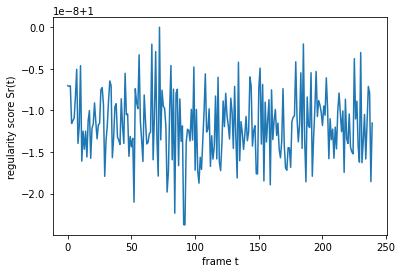

ValueError: ignored

In [ ]:
evaluate()